# Australian Open 2019
BetFair released a data set as part of a datathon competiton to predict the outcome of each game in the 2019 Australian Open.

This is my attempt at performing exploratory analysis and predictions on the data provided in additon to publicly available data to increase the feature size of the data set.

## Import Packages
Import the required packages for reading, exploratory analsysis and visualisation.

In [3]:
import glob
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates
%matplotlib inline
import seaborn as sns 
from datetime import datetime
from datetime import timedelta

sns.set()
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [170]:
ATP = pd.read_csv('ATP_matches.csv',na_values = ['.'])
matchOdds = pd.read_csv('aus_open_men_match_odds.csv',na_values = ['.'])
tournamentOdds = pd.read_csv('aus_open_men_tournament_odds.csv',na_values = ['.'])

## Preliminary Look at the data
Take a peak at the data to get a sense of what it contains.

In [171]:
ATP.head()

,Winner,Loser,Tournament,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,...,Loser_FirstServes_Won,Loser_FirstServes_In,Loser_SecondServes_Won,Loser_SecondServes_In,Loser_BreakPoints_Won,Loser_BreakPoints,Loser_ReturnPoints_Won,Loser_ReturnPoints_Faced,Loser_TotalPoints_Won,Matches Won
0,Edouard Roger-Vasselin,Eric Prodon,Chennai,2-Jan-12,Hard,First Round,106.0,97.0,0,2.0,...,21.0,33.0,13.0,26.0,1.0,3.0,15.0,49.0,49,1
1,Dudi Sela,Fabio Fognini,Chennai,2-Jan-12,Hard,First Round,83.0,48.0,0,2.0,...,17.0,32.0,5.0,26.0,0.0,1.0,8.0,33.0,30,1
2,Go Soeda,Frederico Gil,Chennai,2-Jan-12,Hard,First Round,120.0,102.0,0,2.0,...,45.0,70.0,18.0,35.0,2.0,4.0,36.0,103.0,99,1
3,Yuki Bhambri,Karol Beck,Chennai,2-Jan-12,Hard,First Round,345.0,101.0,0,2.0,...,15.0,33.0,13.0,29.0,2.0,3.0,15.0,46.0,43,1
4,Yuichi Sugita,Olivier Rochus,Chennai,2-Jan-12,Hard,First Round,235.0,67.0,0,2.0,...,19.0,32.0,13.0,22.0,1.0,7.0,30.0,78.0,62,1


In [172]:
matchOdds.head()

,tournament,men_women,match_date,player_1,player_1_odds,player_2,player_2_odds
0,Australian Open 2012,Men,16/01/2012,Adrian Mannarino,12.00,Juan Martin Del Potro,1.08
1,Australian Open 2012,Men,16/01/2012,Albert Montanes,1.38,Pere Riba,3.40
2,Australian Open 2012,Men,16/01/2012,Albert Ramos,27.00,Tomas Berdych,1.02
3,Australian Open 2012,Men,16/01/2012,Alejandro Falla,1.52,Fabio Fognini,2.80
4,Australian Open 2012,Men,18/01/2012,Alejandro Falla,10.50,Mardy Fish,1.10


In [173]:
tournamentOdds.head()

,tournament,men_women,player,odds
0,Australian Open 2012,Men,Novak Djokovic,2.46
1,Australian Open 2012,Men,Roger Federer,5.60
2,Australian Open 2012,Men,Andy Murray,7.60
3,Australian Open 2012,Men,Rafael Nadal,9.00
4,Australian Open 2012,Men,Jo Wilfried Tsonga,22.00


* The ATP matches data contains information on a portion of all matches in the mens international tennis tournaments, since 2012. The winner, loser and date of each match is identified a long with some selected match statistics.
* The Match odds file contains the odds for all Australian Open matches since 2012. 
* The Tournament odds file contains the odds for each player winning the Australian Open since 2012, this differs from the match odds by providing odds for the player becoming the Australian Open Champion for that year. 

The odds file's only contain the odds for the Australian Open tournements, which wont likely provide a significant improvement on our potential predictions.

## Join Additional data

It is always a good idea to see if there is any additional information available, this can be from a multitude of sources, such as personal data sets, data sets available on the web or potentially domain knowledge.

I am aware of a few sources of additional data sets for professional tennis, in my opinion, [tennis-data] is a great source for additional data. This contains results from both the ATP and WTA tours from back to January 2000. This resource includes additional features such as game-by-game scores, additional betting odds, and player ranking points. There is also a project, [The Match Charting Project], that aims to use the crowd to create a data set that includes the shot-by-shot record. Currently there is almost 5000 matches available in the database and will continue to benefit from the contribution of interested fans. The data from this project has not been included here.

I will join this data set with the provided data, to have more features available for the model.

The data is available in seperate files for each year.


[tennis-data]:(http://www.tennis-data.co.uk/index.php)
[The Match Charting Project]:(http://www.tennisabstract.com/charting/meta.html)

In [174]:
# Load the data from each year.
# The files are all labeled in the form '20XX.xlsx'
allFiles = glob.glob("ATP/20*.xlsx")

list_ = []
for file in allFiles:
    list_.append(pd.read_excel(file))

data_All = pd.concat(list_, axis=0, ignore_index=True)
    


## Data Inconsistencies
While attempting to join the two data sets, I have found a number of inconsistencies that need to be dealt with.
1. The tournament names are in different formats.
2. Some tournament locations are different formats.
3. There are some player names that appear to be typos.
4. There is some inconsitencies in the player name format

I will be joining the new data set to the ATP data, so I will try to create a standard format for the tournament location and the player names.

In [175]:
# Strip the tournament locaton.
ATP['Location'] = ATP['Tournament'].str.split(',').apply(lambda x: x[-1].strip())

# Make the location formats consistent.
ATP['Location'] = ATP['Location'].str.replace('-',' ')
# The London tournament refers to a different tournament than Wimbledon, the AEGON Championships
# Wimbledon is 'Wimbledon, London'
ATP['Location'][ATP['Tournament'] == 'London'] = 'Queens Club'  # Mens tournament
ATP['Location'][ATP['Tournament'] == 'Paris'] = 'Bercy'

ATP['Tournament'] = ATP['Tournament'].str.replace('-',' ')
ATP['Tournament'] = ATP['Tournament'].str.split(',').apply(lambda x: x[0].strip())


# Force all player names to lower case for comparison
ATP['Winner'] = ATP['Winner'].str.lower()
ATP['Loser']= ATP['Loser'].str.lower()



### Inconsistent Player Names
The new data set contains a lot of inconsitencies in player names, all of which I had to identify individually and create a correction for each player.

It is conceivable that I did not catch all the differences, but I am confident that I caught most.


In [176]:

# Strip the leading and train spaces from the location
data_All['Location'] = data_All['Location'].str.strip().apply(lambda x: x)
# Strip any hypens in the location names
data_All['Location'] = data_All['Location'].str.replace('-',' ')
data_All['Location'][data_All['Location'] == '\'s Hertogenbosch'] = 's Hertogenbosch'


# Correct some inconsistencies and known typos with the players 
data_All['Winner'][data_All['Winner'] == 'Dolgopolov O.'] = 'Dolgopolov A.'
data_All['Loser'][data_All['Loser'] == 'Dolgopolov O.'] = 'Dolgopolov A.'

data_All['Winner'][data_All['Winner'] == 'Herbert P-H.'] = 'Herbert P.H.'
data_All['Loser'][data_All['Loser'] == 'Herbert P-H.'] = 'Herbert P.H.'

data_All['Winner'][data_All['Winner'] == 'Viola Mat.'] = 'Viola M.'
data_All['Loser'][data_All['Loser'] == 'Viola Mat.'] = 'Viola M.'

data_All['Winner'][data_All['Winner'] == 'Van Der Merwe I.'] = 'Van D. Merwe I.'
data_All['Loser'][data_All['Loser'] == 'Van Der Merwe I.'] = 'Van D. Merwe I.'

data_All['Winner'][data_All['Winner'] == 'Rochus C.'] = 'Rochus O.'
data_All['Loser'][data_All['Loser'] == 'Rochus C.'] = 'Rochus O.'

data_All['Winner'][data_All['Winner'] == 'Granollers-Pujol G.'] = 'Granollers G.'
data_All['Loser'][data_All['Loser'] == 'Granollers-Pujol G.'] = 'Granollers G.'

data_All['Winner'][data_All['Winner'] == 'Delbonis F.'] = 'Del Bonis F.'
data_All['Loser'][data_All['Loser'] == 'Delbonis F.'] = 'Del Bonis F.'

data_All['Winner'][data_All['Winner'] == 'Navarro-Pastor I.'] = 'Navarro I.'
data_All['Loser'][data_All['Loser'] == 'Navarro-Pastor I.'] = 'Navarro I.'

# There are three different Kuznetsov's with the same initials. These players 
# are seperatly identified in the new data set, but I am unable to match them 
# to the supplied data. So, because we are joining the data on four features 
# (Winner, loser, Year, and location), it will be ok, to make all A. Kuznetsov's 
# the same abbreviation. 
# The differences will be identifieable by the other joining features, loser, 
# year and location.
data_All['Winner'][data_All['Winner'] == 'Kuznetsov An.'] = 'Kuznetsov A.'
data_All['Loser'][data_All['Loser'] == 'Kuznetsov An.'] = 'Kuznetsov A.'

data_All['Winner'][data_All['Winner'] == 'Kuznetsov Al.'] = 'Kuznetsov A.'
data_All['Loser'][data_All['Loser'] == 'Kuznetsov Al.'] = 'Kuznetsov A.'


# Force all player names to lower case for comparison
data_All['Winner'] = data_All['Winner'].str.lower()
data_All['Loser'] = data_All['Loser'].str.lower()


In [177]:
# Manually correct the known names that are inconsistent with the derived standard.
def checkNonStandardNames(player):
    '''
    Check for the non standard names that are known and provide 
    correct format for comparison with the ATP data set.
    '''
    newName = -1
    
    if player == 'juan carlos ferrero':
        newName = 'ferrero j.c.'
        
    if player == 'juan ignacio chela':
        newName = 'chela j.i.'
        
    if player == 'sergio gutierrez-ferrol':
         newName = 'gutierrez-ferrol s.'
        
    if player == 'andreas haider-maurer':
        newName = 'haider-maurer a.'

    if player == 'edouard roger-vasselin':
        newName = 'roger-vasselin e.'

    if player == 'pablo carreno busta':
        newName = 'carreno-busta p.'
            
    if player == 'guillermo garcia-lopez':
        newName = 'garcia-lopez g.'
            
    if player == 'mousa shanan zayed':
        newName = 'zayed m.s.'

    if player == 'pierre-hugues herbert':
        newName = 'herbert p.h.'   
            
    if player == 'paul-henri mathieu':
        newName = 'mathieu p.h.'
            
    if player == 'ruben ramirez hidalgo':
        newName = 'ramirez-hidalgo r.'

    if player == 'federico delbonis':
        newName = 'del bonis f.'
            
    if player == 'izak van der merwe':
        newName = 'van d. merwe i.'
        
    if player == 'juan sebastian cabal':
        newName = 'cabal j.s.'
        
    if player == 'daniel munoz de la nava':
        newName = 'munoz-de la nava d.'
                
    if player == 'jonathan dasnieres de veigy':
        newName = 'dasnieres de veigy j.'

    if player == 'albert ramos-vinolas':
        newName = 'ramos a.'

    if player == 'alex bogomolov jr.':
        newName = 'bogomolov a.'

    if player == 'jabor mohammed ali mutawa':
        newName = 'al mutawa j.'

    if player == 'roberto bautista Agut':
        newName = 'bautista r.'

    if player == 'n vijay sundar prashanth':
        newName = 'prashanth v.'

        
    return newName

In [178]:
# Convert all names to a loose common format
# Surname I1. I2. 
# I1 - First initial,
# I2 - second initial
def convertNames(df,column, newColumn):
    '''
    Convert the player names into a common format.

    Some player names do not conform to the standard, which have to be dealt with individually.
    '''

    # Broadcast a defalt value to create the new column
    df[newColumn] = 'none'
    
    # Cycle through each player
    for player in df[column]:

        # Split the full name in to the seperate names
        names = player.split(' ')

        # Create the format based on the length of the names.
        if len(names) == 2:

            if (len(names[0].split('-')) > 1):
                newName = names[1]+' '+names[0].split('-')[0][0]+'.'+names[0].split('-')[1][0]+'.'
            else:
                newName = names[1]+' '+names[0][0]+'.'

        elif len(names) == 3:
            newName = names[1]+' '+names[2]+' '+names[0][0]+'.'

        else:
            newName = names[2]+' '+names[3]+' '+names[0][0]+'.'+names[1][0]+'.'
        
        
        # Check non standard names.
        new = checkNonStandardNames(player)
        if new != -1:
            newName = new
        
        # Apply the newly formated names
        df[newColumn][df[column] == player] = newName

    return df


In [179]:
# Convert all the winners and losers to the standard format. 
ATP = convertNames(ATP,'Winner', 'Winner_merge')
ATP = convertNames(ATP,'Loser', 'Loser_merge')


In [180]:
# Create a feature in each data set for the year of the tournament. 
# This is required when joining the two data sets.
ATP['Tournament_Year'] = pd.to_datetime(ATP['Tournament_Date']).dt.year
data_All['Year'] = data_All['Date'].dt.year


In [181]:
# Join the two data sets together.
joined_Data = pd.merge(ATP,data_All, how='left', 
                       left_on=['Location','Tournament_Year','Winner_merge','Loser_merge'], 
                       right_on=['Location','Year','Winner','Loser'])

# Have a quick look for a sanity check
joined_Data.head()


,Winner_x,Loser_x,Tournament_x,Tournament_Date,Court_Surface,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,...,W1,W2,W3,W4,W5,WPts,WRank,Winner_y,Wsets,Year
0,edouard roger-vasselin,eric prodon,Chennai,2-Jan-12,Hard,First Round,106.0,97.0,0,2.0,...,6.0,6.0,NaN,NaN,NaN,548.0,106.0,roger-vasselin e.,2.0,2012.0
1,dudi sela,fabio fognini,Chennai,2-Jan-12,Hard,First Round,83.0,48.0,0,2.0,...,6.0,6.0,NaN,NaN,NaN,640.0,83.0,sela d.,2.0,2012.0
2,go soeda,frederico gil,Chennai,2-Jan-12,Hard,First Round,120.0,102.0,0,2.0,...,6.0,6.0,7.0,NaN,NaN,481.0,120.0,soeda g.,2.0,2012.0
3,yuki bhambri,karol beck,Chennai,2-Jan-12,Hard,First Round,345.0,101.0,0,2.0,...,6.0,6.0,NaN,NaN,NaN,122.0,345.0,bhambri y.,2.0,2012.0
4,yuichi sugita,olivier rochus,Chennai,2-Jan-12,Hard,First Round,235.0,67.0,0,2.0,...,6.0,6.0,NaN,NaN,NaN,207.0,235.0,sugita y.,2.0,2012.0


# Missing data

Now we need to check if there is any missing data in the data sets.

In [182]:
joined_Data.isnull().sum()

Winner_x                         0
Loser_x                          0
Tournament_x                     0
Tournament_Date                  0
Court_Surface                    0
Round_Description               34
Winner_Rank                    100
Loser_Rank                     297
Retirement_Ind                   0
Winner_Sets_Won                  8
Winner_Games_Won                 0
Winner_Aces                     16
Winner_DoubleFaults             38
Winner_FirstServes_Won           1
Winner_FirstServes_In            1
Winner_SecondServes_Won          2
Winner_SecondServes_In           2
Winner_BreakPoints_Won           7
Winner_BreakPoints               7
Winner_ReturnPoints_Won        376
Winner_ReturnPoints_Faced      376
Winner_TotalPoints_Won           0
Loser_Sets_Won                   8
Loser_Games_Won                  0
Loser_Aces                      18
Loser_DoubleFaults              35
Loser_FirstServes_Won            1
Loser_FirstServes_In             1
Loser_SecondServes_W

# Check for valid values

The joined data has a number of features with missing data which we will address individually.

Some of the features in the ATP data will have analagous features in the additional tennis data. We will be able to use these features to replace some of the NaN values, others we can impute values.

In [183]:
# Convert the date string to a datetime object
#joined_Data['Tournament_Date'] = pd.to_datetime(joined_Data['Tournament_Date'], dayfirst = True, infer_datetime_format=True)

In [184]:
# Round_Description

# While the round descriptions are likely to be different rounds, the simplest way to deal 
# with this feature is to assume the most frequent value.
joined_Data['Round_Description'][joined_Data['Round_Description'].isnull() == True] = joined_Data['Round_Description'].mode()[0]
# - I could potentially determine the round description from the date and tournament, 
# but there aren't that many null values, so this likely wont have a significant impact.


In [185]:
# _Sets_Won

# Close examination of these null values indicates that the winner and loser games won are 
# equal and small (always less than 7). Additionaly, it seems that all of these games 
# were won due to retirement. Therefore we will indicate that all sets won will be zero.
joined_Data['Winner_Sets_Won'][joined_Data['Winner_Sets_Won'].isnull() == True] = 0
joined_Data['Loser_Sets_Won'][joined_Data['Loser_Sets_Won'].isnull() == True] = 0


Because we have two joined data sets with similar features, we can use the second data set to set some of the missing values. The tennis-data data set contains the ranks for the winners and losers that can be used to replace some of the missing values. For the remaining missing values we can try to impute a value.



In [186]:
# _Rank

# I will check if there is any valid value from the new data set for the missing ranks.
# For the remaining missing values we can assume the player is not ranked yet, 
# so I'll give them one.
winnerIdx = list(joined_Data[joined_Data['Winner_Rank'].isnull() == True].index)

for index in winnerIdx:
    
    if np.isnan(joined_Data['Winner_Rank'].iloc[index]) and not np.isnan(joined_Data['WRank'].iloc[index]):
        joined_Data['Winner_Rank'].iloc[index] = joined_Data['WRank'].iloc[index]

loserIdx = list(joined_Data[joined_Data['Winner_Rank'].isnull() == True].index)

for index in loserIdx:
    
    if np.isnan(joined_Data['Loser_Rank'].iloc[index]) and not np.isnan(joined_Data['LRank'].iloc[index]):
        joined_Data['Loser_Rank'].iloc[index] = joined_Data['LRank'].iloc[index]

        
# Assign a rank to the remaining missing values
joined_Data['Winner_Rank'][joined_Data['Winner_Rank'].isnull() == True] = joined_Data['Winner_Rank'].max()
joined_Data['Loser_Rank'][joined_Data['Loser_Rank'].isnull() == True] = joined_Data['Loser_Rank'].max()


In [187]:
# _Aces

# The new data set does not have aces count, so we can't 
# use this to replace some missing values in our data.

# Most games dont have many aces at all, so I will assume that neither 
# of the players in these games score an ace.
joined_Data['Winner_Aces'][joined_Data['Winner_Aces'].isnull() == True] = 0
joined_Data['Loser_Aces'][joined_Data['Loser_Aces'].isnull() == True] = 0


In [188]:
# _DoubleFaults

# The new data set does not have double fault count, so we can't 
# use this to replace some missing values in our data.

# Imputing double faults is more difficult, but after trying a few options like, 
# minimum, maximum, average, and mode. I will assume the real value is closer 
# to the most frequent value.
joined_Data['Winner_DoubleFaults'][joined_Data['Winner_DoubleFaults'].isnull() == True] = joined_Data['Winner_DoubleFaults'].mode()[0]
joined_Data['Loser_DoubleFaults'][joined_Data['Loser_DoubleFaults'].isnull() == True] = joined_Data['Loser_DoubleFaults'].mode()[0]


In [189]:
# _FirstServes_Won

# There's no easy way to determine what the number of first serves won is from the 
# existing data, so we will assume the most frequent value.
joined_Data['Winner_FirstServes_Won'][joined_Data['Winner_FirstServes_Won'].isnull() == True] = joined_Data['Winner_FirstServes_Won'].mode()[0]
joined_Data['Loser_FirstServes_Won'][joined_Data['Loser_FirstServes_Won'].isnull() == True] = joined_Data['Loser_FirstServes_Won'].mode()[0]

# _FirstServes_In

# Much like the first serves won, there is no easy way to determine the number of first 
# serves in, when looking at the existing data. So we will assume the most frequent value.
joined_Data['Winner_FirstServes_In'][joined_Data['Winner_FirstServes_In'].isnull() == True] = joined_Data['Winner_FirstServes_In'].mode()[0]
joined_Data['Loser_FirstServes_In'][joined_Data['Loser_FirstServes_In'].isnull() == True] = joined_Data['Loser_FirstServes_In'].mode()[0]


In [190]:
# _SecondServes_Won

# Similar to the first serves won/in, there is no easy way to determine the number of second 
# serves won, when looking at the existing data. So we will assume the most frequent value.
joined_Data['Winner_SecondServes_Won'][joined_Data['Winner_SecondServes_Won'].isnull() == True] = joined_Data['Winner_SecondServes_Won'].mode()[0]
joined_Data['Loser_SecondServes_Won'][joined_Data['Loser_SecondServes_Won'].isnull() == True] = joined_Data['Loser_SecondServes_Won'].mode()[0]

# _SecondServes_In

# Again, similar to the last few featuers, there is no easy way to determine the number of second 
# serves in, when looking at the existing data. So we will assume the most frequent value.
joined_Data['Winner_SecondServes_In'][joined_Data['Winner_SecondServes_In'].isnull() == True] = joined_Data['Winner_SecondServes_In'].mode()[0]
joined_Data['Loser_SecondServes_In'][joined_Data['Loser_SecondServes_In'].isnull() == True] = joined_Data['Loser_SecondServes_In'].mode()[0]


In [191]:
# _BreakPoints

# Break points are similar to aces, in the fact that they don't occur often in matches, so 
# I will assume no break points were seen.
joined_Data['Winner_BreakPoints'][joined_Data['Winner_BreakPoints'].isnull() == True] = 0
joined_Data['Loser_BreakPoints'][joined_Data['Loser_BreakPoints'].isnull() == True] = 0

# _BreakPoints_Won

# I have made the ascertion that break points don't occur too often, so if they don't 
# occur, they can't be won
joined_Data['Winner_BreakPoints_Won'][joined_Data['Winner_BreakPoints_Won'].isnull() == True] = 0
joined_Data['Loser_BreakPoints_Won'][joined_Data['Loser_BreakPoints_Won'].isnull() == True] = 0




In [192]:
# _ReturnPoints_Won

# The number of return points won varies significantly between matches, so there is no 
# simple value to use here. I will assume the most frequent value.
joined_Data['Winner_ReturnPoints_Won'][joined_Data['Winner_ReturnPoints_Won'].isnull() == True] = joined_Data['Winner_ReturnPoints_Won'].mode()[0]
joined_Data['Loser_ReturnPoints_Won'][joined_Data['Loser_ReturnPoints_Won'].isnull() == True] = joined_Data['Loser_ReturnPoints_Won'].mode()[0]
# - It may be possible to make a reasonable estimate based on the number of games played and 
# sets won, but I will leave this until later enhancements.


In [193]:
# _ReturnPoints_Faced

# We can make a reasonable minimum estimate of the points faced based on the number of opponents serves in.
loserPtsFaced = joined_Data['Winner_FirstServes_In'][joined_Data['Loser_ReturnPoints_Faced'].isnull() == True] + joined_Data['Winner_SecondServes_In'][joined_Data['Loser_ReturnPoints_Faced'].isnull() == True]
joined_Data['Loser_ReturnPoints_Faced'][joined_Data['Loser_ReturnPoints_Faced'].isnull() == True] = loserPtsFaced

winnerPtsFaced = joined_Data['Loser_FirstServes_In'][joined_Data['Winner_ReturnPoints_Faced'].isnull() == True] + joined_Data['Loser_SecondServes_In'][joined_Data['Winner_ReturnPoints_Faced'].isnull() == True]
joined_Data['Winner_ReturnPoints_Faced'][joined_Data['Winner_ReturnPoints_Faced'].isnull() == True] = winnerPtsFaced



In [194]:
# NEW FEATURE

# The number of ranking points the player has going into the tournament.

# There is no way to estimate the player points going into each tournament, so I will set them to zero.
joined_Data['WPts'][joined_Data['WPts'].isnull() == True] = 0
joined_Data['LPts'][joined_Data['LPts'].isnull() == True] = 0


In [195]:
# NEW FEATURE

# The scores for each set of the match for each player.

# We can assume the games won in each set, by setting the winner to 6 and the 
# loser to the average value for games won in each set by the losing player.
# - I know that only the mens Grand Slam tournaments are 5 setters, so we can 
# assume that each tournament is best of 3, so sets 4 and 5 will be 0.
joined_Data['W1'][joined_Data['W1'].isnull() == True] = 6
joined_Data['L1'][joined_Data['L1'].isnull() == True] = int(joined_Data['L1'].mean())
joined_Data['W2'][joined_Data['W2'].isnull() == True] = 6
joined_Data['L2'][joined_Data['L2'].isnull() == True] = int(joined_Data['L2'].mean())
joined_Data['W3'][joined_Data['W3'].isnull() == True] = 0
joined_Data['L3'][joined_Data['L3'].isnull() == True] = 0
joined_Data['W4'][joined_Data['W4'].isnull() == True] = 0
joined_Data['L4'][joined_Data['L4'].isnull() == True] = 0
joined_Data['W5'][joined_Data['W5'].isnull() == True] = 0
joined_Data['L5'][joined_Data['L5'].isnull() == True] = 0


In [196]:
# NEW FEATURE

# The match score for each player.

# Having a look at the data, shows that when the winner sets and loser sets 
# are empty, the game was not completed and is categorised as a walkover.
joined_Data['Wsets'][joined_Data['Wsets'].isnull() == True] = 0
joined_Data['Lsets'][joined_Data['Lsets'].isnull() == True] = 0


In [197]:
# NEW FEATURE

# Where the available betting agency odds are empty, I will assume equal likelyhood of each player winning
joined_Data['B365W'][joined_Data['B365W'].isnull() == True] = 1
joined_Data['B365L'][joined_Data['B365L'].isnull() == True] = 1
joined_Data['EXW'][joined_Data['EXW'].isnull() == True] = 1
joined_Data['EXL'][joined_Data['EXL'].isnull() == True] = 1
joined_Data['LBW'][joined_Data['LBW'].isnull() == True] = 1
joined_Data['LBL'][joined_Data['LBL'].isnull() == True] = 1
joined_Data['PSW'][joined_Data['PSW'].isnull() == True] = 1
joined_Data['PSL'][joined_Data['PSL'].isnull() == True] = 1
joined_Data['SJW'][joined_Data['SJW'].isnull() == True] = 1
joined_Data['SJL'][joined_Data['SJL'].isnull() == True] = 1


In [198]:
# NEW FEATURE

# Court Type

# Having a look at the data, indicates that there are very few instances 
# where the court type is not defined. Considering most tournaments are 
# outdoor, we will assume the missing values are outdoor tournaments
joined_Data['Court'][joined_Data['Court'].isnull() == True] = 'Outdoor'

# - Possibly could try to find a valid value for the tournament (transform by tournament)

In [199]:
# Surface

# I will check if there is any valid value from the new feature set to 
# provide a value for the missing ones. For the remaining missing values 
# we can assume the most common value, which is likely to be 'Hard', 
# but I'll leave it up to the data to decise.
surfaceIdx = list(joined_Data[joined_Data['Surface'].isnull() == True].index)

for index in surfaceIdx:
    
    if math.isnan(joined_Data['Surface'].iloc[index]) and not joined_Data['Court_Surface'].iloc[index]:
        joined_Data['Surface'].iloc[index] = joined_Data['Court_Surface'].iloc[index]

joined_Data['Surface'][joined_Data['Surface'].isnull() == True] = joined_Data['Surface'].mode()[0]


In [200]:
# Series

# There are a number of missing values for the Series feature. We can use a proxy of the 
# number of games played in the tournament. We need to count the number of games in each 
# tournament and apply the value to each tournament.
joined_Data['Series_Games'] = joined_Data.groupby('Tournament_x')['Tournament_x'].transform('count')

# Now we can calculate the 90th percentile for the existing values in each Series and 
# use this as the threshold to determine which Series the tournement should be.
quantiles = joined_Data.groupby('Series')['Series_Games'].quantile(.9)


joined_Data['Series'][(joined_Data['Series'].isnull() == True) & 
                      (joined_Data['Series_Games'] <= quantiles['ATP250'])] = 'ATP250'
joined_Data['Series'][(joined_Data['Series'].isnull() == True) & 
                      (joined_Data['Series_Games'] <= quantiles['ATP500'])] = 'ATP500'
joined_Data['Series'][(joined_Data['Series'].isnull() == True) & 
                      (joined_Data['Series_Games'] <= quantiles['Masters 1000'])] = 'Masters 1000'
joined_Data['Series'][(joined_Data['Series'].isnull() == True) & 
                      (joined_Data['Series_Games'] <= quantiles['Masters Cup'])] = 'Masters Cup'
joined_Data['Series'][(joined_Data['Series'].isnull() == True) & 
                      (joined_Data['Series_Games'] > quantiles['Masters Cup'])] = 'Grand Slam'


In [201]:
# Best of

# This is the maximum number of sets player per match for the tournament.
# The mens Grand Slam tournaments are the only tournements that have a 
# best of 5 set count, so we we can set the missing values based on the Series.
joined_Data['Best of'][(joined_Data['Best of'].isnull() == True) & (joined_Data['Series'] == 'Grand Slam')] = 5
# The remaining are best of 3 sets.
joined_Data['Best of'][joined_Data['Best of'].isnull() == True] = 3



In [202]:
# Date

# This is the date the match was played. Many of these matches are 
# qualifying matches so are not included additional tennis data we added 
# in. So we can assume the tournament data for the missing values
joined_Data['Date'][joined_Data['Date'].isnull() == True] = pd.to_datetime(joined_Data['Tournament_Date'][joined_Data['Date'].isnull() == True],dayfirst =True)
joined_Data['Year'][joined_Data['Year'].isnull() == True] = joined_Data['Date'].dt.year



In [203]:
# Comment

# This feature describes how the game was completed, with possible values 
# of retired, walkover or disqualified. We will make the assumption that 
# all matches were completed.
joined_Data['Comment'][joined_Data['Comment'].isnull() == True] = 'Completed'

## Remove the Duplicate Features
After dealing with all the missing values I will remove the duplicate features from joining the two data sets. I will also rename some features for clarity.

In [204]:
joined_Data.drop(['ATP','AvgL','AvgW','Court_Surface', 'Loser_merge','Loser_y','LRank',
                  'Round','Tournament_y','Winner_merge','Winner_y','WRank',
                  'Tournament_Year','Year','MaxW','MaxL','SJW','SJL'], 
                  axis=1, inplace=True)

joined_Data.rename(columns={'Loser_x': 'Loser', 'LPts': 'Loser_RankPts',
                            'Lsets': 'Loser_Sets', 'Tournament_x': 'Tournament',
                            'Winner_x': 'Winner', 'WPts': 'Winner_RankPts',
                            'Wsets': 'Winner_Sets'}, inplace=True)


In [205]:
joined_Data.isnull().sum()

Winner                       0
Loser                        0
Tournament                   0
Tournament_Date              0
Round_Description            0
Winner_Rank                  0
Loser_Rank                   0
Retirement_Ind               0
Winner_Sets_Won              0
Winner_Games_Won             0
Winner_Aces                  0
Winner_DoubleFaults          0
Winner_FirstServes_Won       0
Winner_FirstServes_In        0
Winner_SecondServes_Won      0
Winner_SecondServes_In       0
Winner_BreakPoints_Won       0
Winner_BreakPoints           0
Winner_ReturnPoints_Won      0
Winner_ReturnPoints_Faced    0
Winner_TotalPoints_Won       0
Loser_Sets_Won               0
Loser_Games_Won              0
Loser_Aces                   0
Loser_DoubleFaults           0
Loser_FirstServes_Won        0
Loser_FirstServes_In         0
Loser_SecondServes_Won       0
Loser_SecondServes_In        0
Loser_BreakPoints_Won        0
                            ..
Location                     0
B365L   

In [206]:
#joined_Data.to_csv('joined_Data.csv',index=False)

# EDA

Now that I have dealt with all the missing data, I can start to explore the data.

## Series Tournaments

The newly added data set gives us a indication of the distribution of matches played in each ATP Series. The tournaments will offer a different amount of world ranking points and prize money. In addition there are limited positions available for each tournament, where each player needs to announce their intention to play each specific tournament. 

 - There are 40 [ATP 250 Series] tournements per year, with 28 players per tournament.
 - There are 13 [ATP 500 Series] tournaments per year, with 32 players per tournament. It is a requirement for the leading players to play at least 4 of these tournaments per year to qualify for world ranking points.
 - There are 9 [ATP 1000 Series] tournaments per year, with 96 players per tournament.
 - There is only 1 [Masters Cup] tournament per year, held in London. Also known as the ATP Finals, and are the season-ending championships of the ATP World Tour.
 - There are 4 [Grand Slam] tournaments per year with 128 players per tournament. The Grand Slams offer the most ranking points, prize money, public and media attention.
 
 [ATP 250 Series]:(https://en.wikipedia.org/wiki/ATP_World_Tour_250_series)
 [ATP 500 Series]:(https://en.wikipedia.org/wiki/ATP_World_Tour_500_series)
 [ATP 1000 Series]:(https://en.wikipedia.org/wiki/ATP_World_Tour_Masters_1000)
 [Masters Cup]:(https://en.wikipedia.org/wiki/ATP_Finals)
 [Grand Slam]:(https://en.wikipedia.org/wiki/Grand_Slam_(tennis))


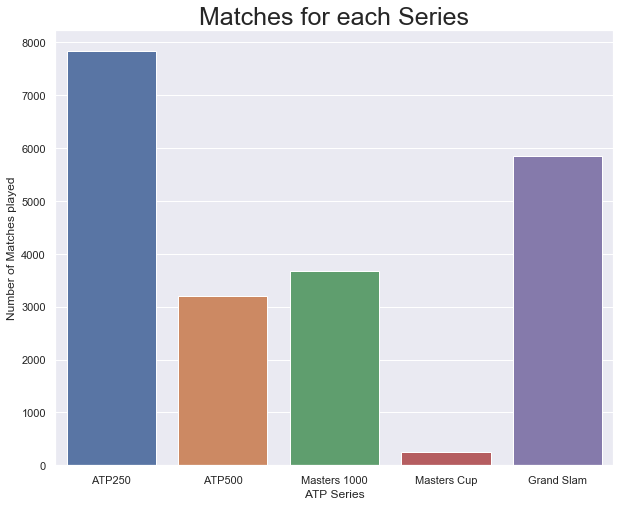

In [207]:
plt.figure(figsize=(10,8))
sns.countplot(joined_Data['Series'], order = ['ATP250','ATP500','Masters 1000','Masters Cup','Grand Slam'])
plt.title('Matches for each Series',fontsize=25)
plt.xlabel('ATP Series')
plt.ylabel('Number of Matches played')
plt.show()

Most matches are played as part of an ATP250 series tournament, which is likely due to the fact that there are more ATP250 tournaments available and players aquiring world ranking points. The players with higher ranking points allow  garaunteed entry in to some of the more desired tournements, such as the Grand Slams.

The Masters Cup tournement is the season ending championship of the ATP tour, consisting of the top 8 singles players. This would explain why there are so few Masters Cup matches in the data set.

### What porportion of the Data is Australian Open  Matches
Since we are concerned with predicting the results of the Australian Open, lets see how much of our data is represented by previous Australian open tournaments.


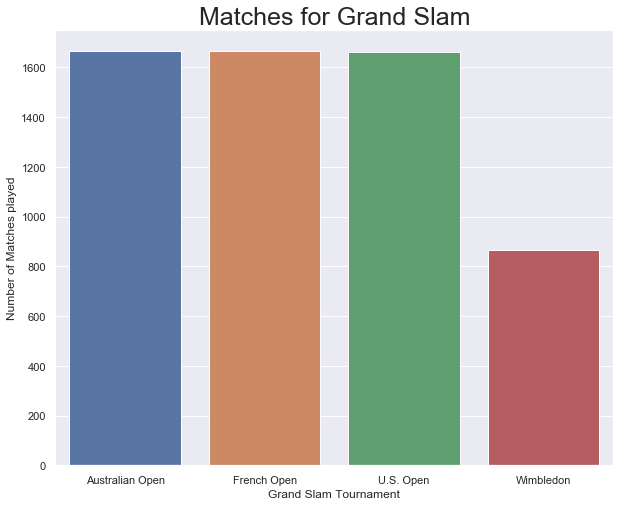

In [208]:
GrandSlams = joined_Data[joined_Data['Series'] == 'Grand Slam']

plt.figure(figsize=(10,8))
sns.countplot(GrandSlams['Tournament'], order = ['Australian Open','French Open','U.S. Open','Wimbledon'])
plt.title('Matches for Grand Slam',fontsize=25)
plt.xlabel('Grand Slam Tournament')
plt.ylabel('Number of Matches played')
plt.show()


In [209]:
total = GrandSlams.groupby('Tournament')['Tournament'].count().sum()

round(GrandSlams.groupby('Tournament')['Tournament'].count()/total*100,2)



Tournament
Australian Open    28.44
French Open        28.42
U.S. Open          28.39
Wimbledon          14.76
Name: Tournament, dtype: float64

In [210]:
total = joined_Data.groupby('Tournament')['Tournament'].count().sum()
tournament_Count = joined_Data.groupby('Tournament')['Tournament'].count()/total*100

print ('{0:0.3}%'.format(tournament_Count['Australian Open']))

7.99%


It seems that most of the Grand Slams are evenly represented, and about 8.0% of the data represents the previous Australian Open tournaments 

## Surface
We can have a look at the number of matches played on each surface.

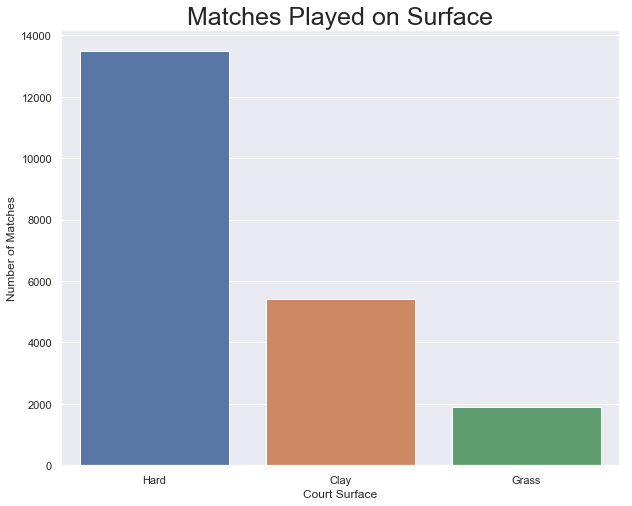

In [211]:
# distribution of surface
plt.figure(figsize=(10,8))
sns.countplot(joined_Data['Surface'].astype('str'))
plt.title('Matches Played on Surface',fontsize=25)
plt.xlabel('Court Surface')
plt.ylabel('Number of Matches')
plt.show()

Most Matches are played on Hard court and Clay.

## Matches per Round

Now lets look at the number of matches player per round. 

You would expect that most matches are played in the early rounds as all players have to go through each round until they've won all the matches they play in the tournament to win.

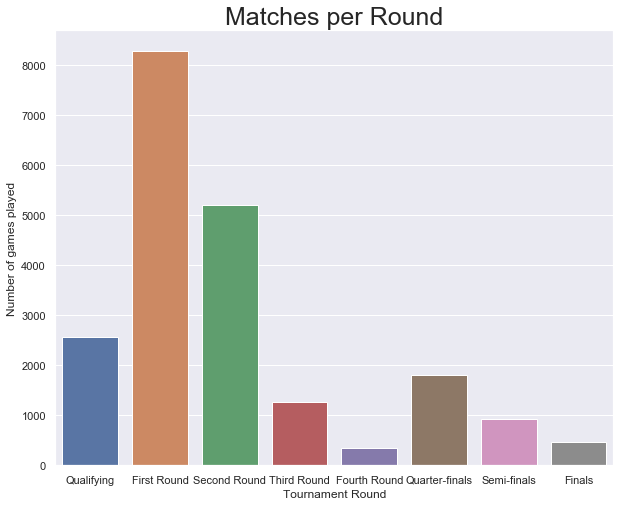

In [212]:
# distribution of round
plt.figure(figsize=(10,8))
sns.countplot(joined_Data['Round_Description'], 
              order=['Qualifying','First Round','Second Round','Third Round','Fourth Round',
                     'Quarter-finals','Semi-finals','Finals'])
plt.title('Matches per Round',fontsize=25)
plt.xlabel('Tournament Round')
plt.ylabel('Number of games played')
plt.show()

Our assumption is some what true for the first four rounds.

However, you may notice that the first round, the "Qualifying" round, there is fewer matches than the first round. This is because, not all players have to qualify for each tournament. In most cases, the top players will gain automatic entry to a tournament, where as the lower ranked players need to fight for their chance to play in each tournament. 

Also, in some of the major tournaments, some of the lower ranked players may be awarded a wild card entry, which is usually decided by the national federation/association holding the tournament.

## Matches played
We can have a look at the number of matches won and matches played, but first we have to determine the value for each player at each tournament.

In [213]:
# Count the number of times the player has won
joined_Data = joined_Data.sort_values(by=['Date'], ascending = False)

joined_Data['Winner_Matches_Won'] = 0
joined_Data['Winner_Matches_Played'] = 0

playerWinCount = {}
playerMatchCount = {}

for idx in range(len(joined_Data)):
    
    key = joined_Data.iloc[idx]['Winner']
    
    # Count the number of matches won
    if key in playerWinCount.keys():
        playerWinCount[key] += 1
    else:
        playerWinCount[key] = 1
    
    # Number of mathes won coming into the current match
    joined_Data['Winner_Matches_Won'].iloc[idx] = playerWinCount.get(key)-1
    
    # Count the number of mathces played as time progresses.
    if key in playerMatchCount.keys():
        playerMatchCount[key] += 1
    else:
        playerMatchCount[key] = 1
    
    LoserKey =  joined_Data.iloc[idx]['Loser']

    if LoserKey in playerMatchCount.keys():
        playerMatchCount[LoserKey] += 1
    else:
        playerMatchCount[LoserKey] = 1

    # Number of mathes played coming into the current match
    joined_Data['Winner_Matches_Played'].iloc[idx] = playerMatchCount.get(key)-1
    

In [214]:
# We can use these additional features together to calculate the match percentage for 
# each player and see how that corresponds to the rank.
joined_Data['Winner_Match_Percentage'] =  joined_Data['Winner_Matches_Won']/joined_Data['Winner_Matches_Played']

We Shouldn't use the progressive match percentage, because this will be over inflated for the early matches. We can use the latest match percentage for all matches seen as a measure of a players win performance.

In [215]:
# Select the max number of games for each player
allPlayers = pd.unique(joined_Data[['Winner']].values.ravel('K'))

joined_Data['Winner_Career_Match_Percentage'] = 0

for player in allPlayers:
    
    # Get the last Match Percentage - This is the most recent career match percentage.
    value = joined_Data[joined_Data['Winner'] == player].iloc[-1]['Winner_Match_Percentage']
    
    # Assign the value to career match percentage for all player entries.
    joined_Data['Winner_Career_Match_Percentage'][joined_Data['Winner'] == player] = value

In [216]:
# Drop the features that are over inflated, the progressive win percentage
joined_Data.drop(['Winner_Match_Percentage'] ,axis=1, inplace=True)

In [217]:

def Get_Loser_Feature(data, feature):
    '''
    Apply the feature to the losing player. This relies on the 
    loser players winning at least one match in the data set.
    '''
    
    # Set the feature labels
    newFeature = 'Loser_'+feature
    winFeature = 'Winner_'+feature

    data[newFeature] = 0

    # Get a list of all the losing players
    players = list(set(data['Loser']))

    for player in players:

        # Find where the player is a winner
        value = data[winFeature][data['Winner'] == player]

        if value.empty:
            # The player never won a match
            value = pd.Series([0])

        # Apply this value to all rows where the player is the loser
        data[newFeature][data['Loser'] == player] = value.iloc[0]


    return data



In [218]:
joined_Data = Get_Loser_Feature(joined_Data, 'Matches_Won')
joined_Data = Get_Loser_Feature(joined_Data, 'Matches_Played')
#joined_Data = Get_Loser_Feature(joined_Data, 'Match_Percentage')
joined_Data = Get_Loser_Feature(joined_Data, 'Career_Match_Percentage')



In [219]:
joined_Data.head()

,Winner,Loser,Tournament,Tournament_Date,Round_Description,Winner_Rank,Loser_Rank,Retirement_Ind,Winner_Sets_Won,Winner_Games_Won,...,W5,Winner_RankPts,Winner_Sets,Series_Games,Winner_Matches_Won,Winner_Matches_Played,Winner_Career_Match_Percentage,Loser_Matches_Won,Loser_Matches_Played,Loser_Career_Match_Percentage
19764,novak djokovic,kevin anderson,Wimbledon,2-Jul-18,Finals,21.0,8.0,0,3.0,19,...,0.0,8045.0,2.0,1119,0,0,0.871369,0,1,0.607500
20827,andrey rublev,liam caruana,Milan,5-Nov-18,First Round,68.0,599.0,0,3.0,12,...,0.0,0.0,0.0,12,0,0,0.504505,0,0,0.000000
20826,hubert hurkacz,jaume antoni munar clar,Milan,5-Nov-18,First Round,85.0,76.0,0,3.0,17,...,0.0,0.0,0.0,12,0,0,0.545455,0,1,0.551724
20825,frances tiafoe,hubert hurkacz,Milan,5-Nov-18,First Round,40.0,85.0,0,3.0,14,...,0.0,0.0,0.0,12,0,0,0.456522,0,0,0.545455
20824,jaume antoni munar clar,frances tiafoe,Milan,5-Nov-18,First Round,76.0,40.0,0,3.0,12,...,0.0,0.0,0.0,12,0,1,0.551724,0,0,0.456522


(0, 750)

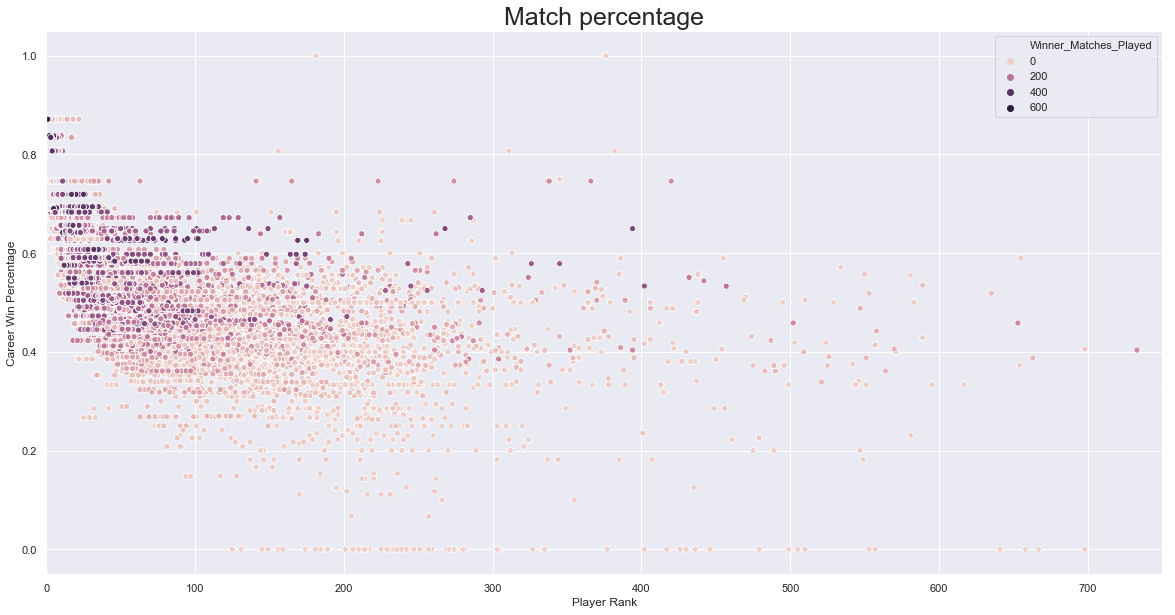

In [220]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x='Winner_Rank', y='Winner_Career_Match_Percentage', hue='Winner_Matches_Played', ax=ax, data=joined_Data)
plt.title('Match percentage',fontsize=25)
plt.xlabel('Player Rank')
plt.ylabel('Career Win Percentage')
plt.legend(loc='upper right')
plt.xlim(0,750)

We can see that the higher ranked players have played more matches and have a higher win percentage. This would indicate that the more experience a player gets, the better chance they have of achieving a higher rank.

## Rank Progression
We can try to see how the rank for each player progresses through their careers. 

We wont be able to visualise all the players in the data set, so we will just look at the players that reached the top 3 at some point in their careers.

In [221]:
# Find the best rank each player reached
joined_Data = joined_Data.sort_values(by='Winner_Rank',ascending=True)
joined_Data['Best_Rank'] = joined_Data.groupby('Winner')['Winner_Rank'].transform('min')

# Select the players that reached the top 3
players = list(set(joined_Data[joined_Data['Best_Rank'] <= 3]['Winner']))

# Create a dataframe with only the top players
topPlayers = pd.DataFrame()
for player in players:
    
    topPlayers = topPlayers.append(joined_Data[joined_Data['Winner'] == player])
    
    

Text(0,0.5,'Player rank')

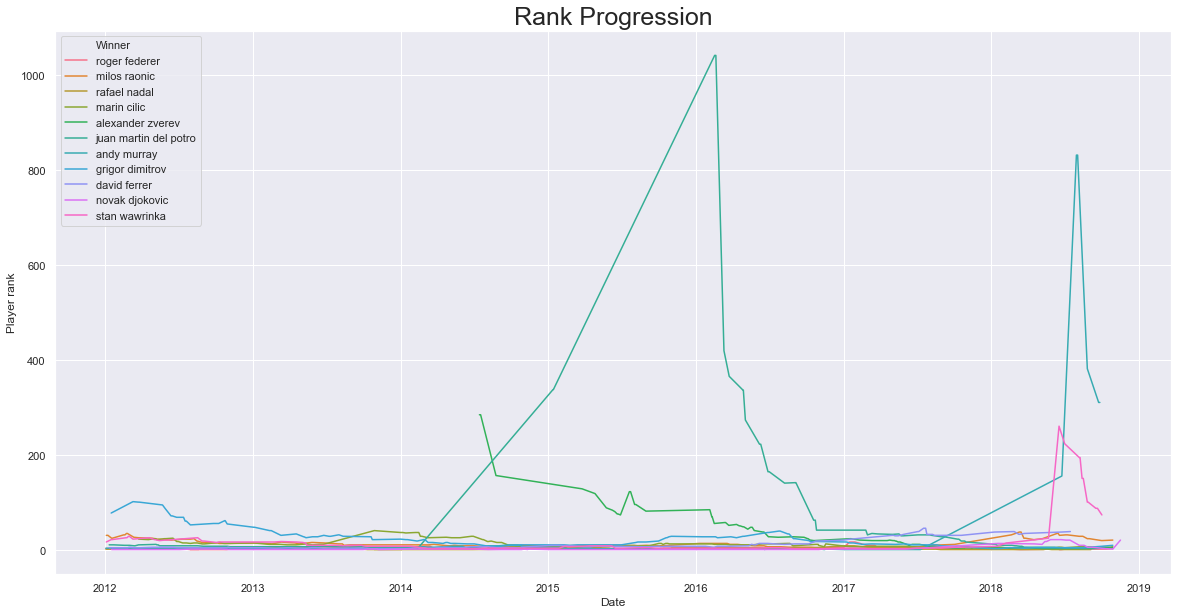

In [222]:
# Plot the rank progression of all the top players.
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="Date", y="Winner_Rank", hue="Winner",ax=ax, data=topPlayers)
plt.title('Rank Progression',fontsize=25)
plt.xlabel('Date')
plt.ylabel('Player rank')

We can see most players approach the higher ranks as they progress through their career, but there are a couple of players that stick out.

 - [Jaun Martin del Potro] had to withdraw from competition after a left wrist injury, returning in 2016 where he found some strong form to regain his previous career high ranking of 4 and progressed to world no. 3 in August 2018.

 - [Andy Murray] also dropped in ranking due to withdrawing from several tournaments in 2018 due to a hip injury, and has started to regain his ranking after rehab.


[Jaun Martin del Potro]:(https://en.wikipedia.org/wiki/Juan_Mart%C3%ADn_del_Potro)
[Andy Murray]:(https://en.wikipedia.org/wiki/Andy_Murray)

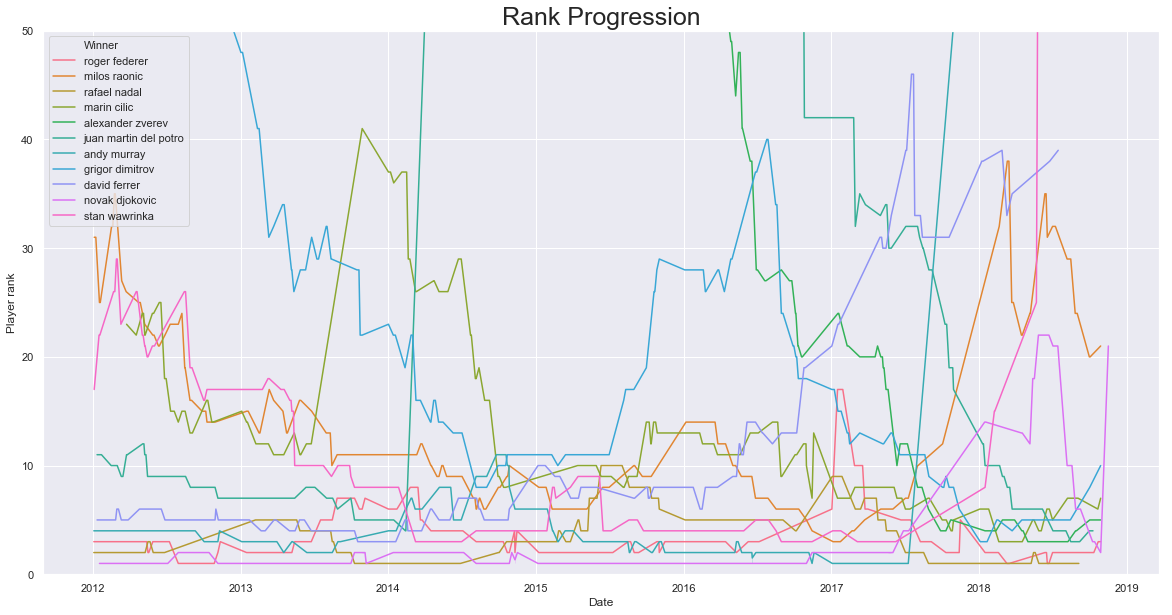

In [223]:
# Rescale the above figure to see more detail at the "higher" ranks
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="Date", y="Winner_Rank", hue="Winner",ax=ax, data=topPlayers)
plt.title('Rank Progression',fontsize=25)
plt.xlabel('Date')
plt.ylabel('Player rank')
plt.ylim(0, 50)
plt.legend(loc='upper left')
#sns.plt.xlim(0, None)

If we zoom in on the "Higher" ranks we can see most players seem to oscillate around the "higher" ranks.

In [ ]:

# Fix these features to only use the games previous to current one - fix the DATA LEAK

## Feature Engineering

We've already created a few extra features, looking at the number of games played and the progression of games won compared to the games played.

Now, we'll do some research and use our domain kowledge of sport, and Tennis in particular to generate some additional features that may be useful. 

1. **Rank Difference**
A player with a much higher rank is likely to have a better chance in winning over a lower ranked player.
2. **Elo Ranking**
This is analagous to the [Elo ranking] from Chess, where a player gains and looses points based on the outcome of the game. The number of points gained or lost in each match will depend on the opponents elo ranking. Some work has been done to develop a [tennis specific Elo ranking] formula to better represent the game of tennis, with some [blogs] comparing all the open era players on an even footing.

 The reasoning for the elo ranking is the same as the rankings, a higher ranked palyer is likely to defeat a lower ranked player. The elo ranking is generally considered a better estimate of a players ability at any given time, because it takes into account the abiolity of the opponent at the time.

3. **Elo Ranking Difference**
The difference in Elo ranking is analoagous to the difference in ranking.
4. **Career Features**
We can make the assumption that a player with better career statistics is more likely to defeat a player with lessor career statics. We will simply total some of the features for each player, incuding both the times they win the match and lose.
5. **Serving Strength** 
We can define the serving strength of a player by the number of games they win on serve compared to the number of games they serve for. This can also be specified againts a specific player as discussed in this [research]. We may attempt to apply this reseach to our feature engineering.
6. **Recieving Strength**
We can define the receiving strength of a player by the numebr of games they win on return compared to the number of games they play on return. This is analgous to the serving strength, and ca be specified to each opponent
7. **Career Ace rate**
We can hypothesis that a better player will serve more aces per first serves in than a lessor player. We can normalise the number of aces served in a match to provide an equal comparison between these players.
8. **Career Double Faults rate**
Similar to the Aces, we can hypothesis that a better player will serve less double faults. We will normalise the number of double faults in a match , in order to provide an equal comparison of double faults for each player.
9. **Career Return Pts Won rate**
The return points won indicates that a player is heading towards breaking the opponents serve and closer to winning a set. We will use the proportion of return points won to the total return points faced, which could be a proxy measure of the return strength.
10. **Recent Performance**
The recent hisotory of a player indicates how well they are playing in a more recent period of time. This is aimed to capture the improving players as they defeat higher and higher ranks as they progress through recent tournaments.

 The recent history of a player may play a role in their chance of winning a match. This should be over a longer period than a single tournament. We can use the proportion of games won to the total games played over different periods to determine this. We will use a 3 month period to span over potentially several tournaments and to gaurantee at least 10 samples.
11. **Recent Performance on Hard Court**
This is analagous to the recent history feature above, just specific to the Australian Open court surface, hard court. The recent history of a player on Hard court may provide some additional benefit to predicting the winner of a match at the Australian Open. The period used is the same preiod used in the above feature.
12. **Career Performance Hard Court**
We have already created the career features that determines the players career match percentage, we can expand this out to include only the hard court surface.

    ---
 #### More Complex Features
 
13. **Game Win Probability** 
If we assume that any point in a game is a Bernoulli random variable, we can calculate the win probability of a certain player winning a match using the formula derived by [O'Malley]. This is analagous to our target variable.
14. **Common Opponent**
The [common opponent] approach aims to eliminate the potential bias of the serving strength and recieveing strength.

We will refer to [additional research] for more features.

[Elo ranking]:(https://en.wikipedia.org/wiki/Elo_rating_system)
[tennis specific Elo ranking]:(https://www.stat.berkeley.edu/~aldous/157/Old_Projects/huang.pdf)
[blogs]:(https://fivethirtyeight.com/features/djokovic-and-federer-are-vying-to-be-the-greatest-of-all-time/)
[research]:(https://project-archive.inf.ed.ac.uk/msc/20172425/msc_proj.pdf)
[common opponent]:(https://www.sciencedirect.com/science/article/pii/S0898122112002106#br000050)
[additional research]:[https://www.doc.ic.ac.uk/teaching/distinguished-projects/2015/m.sipko.pdf)
[O'Malley]:(https://www.degruyter.com/view/j/jqas.2008.4.2/jqas.2008.4.2.1100/jqas.2008.4.2.1100.xml?format=INT&intcmp=trendmd)


### Rank Difference

In [224]:
joined_Data['Rank_Difference'] = joined_Data['Loser_Rank'] - joined_Data['Winner_Rank'] 

### Elo Ranking
There is a lot of sources available on the web that already perform the elo ranking calcualtions, so I wont "re-invent the wheel", I'll just modify existing code to support our data set.

Here the code to calculate the Elo ranking is taking from [Eduard Thomas'] GitHub page.

[Eduard Thomas']:(https://github.com/edouardthom/ATPBetting)

In [225]:

def computeEloRanking(data, k=32):
    '''
    Source code: https://github.com/edouardthom/ATPBetting
    
    Given the list on matches in chronological order, for each match, compute
    the elo ranking of the 2 players at the beginning of the match
    
    '''
    
    players = list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo = pd.Series(np.ones(len(players))*1500, index = players)
    elo_ranking=[(1500,1500)]

    for i in range(1,len(data)):
        
        winner = data.iloc[i-1,:].Winner
        loser = data.iloc[i-1,:].Loser
        
        winner_elo = elo[winner]
        loser_elo = elo[loser]
        
        # Calcualte the probability of winning
        winProbability = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))    
        
        # Calcualte the new elo ranking
        new_winner_elo = winner_elo + k * (1 - winProbability)
        new_loser_elo = loser_elo - k * (1 - winProbability)
        
        # Re-assign the new elo ranking to the players
        elo[winner] = new_winner_elo
        elo[loser] = new_loser_elo
        
        # Add the new rankings to the list
        elo_ranking.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        
        
    # Form a data frame of the elo rankings
    elo_ranking = pd.DataFrame(elo_ranking, columns = ["elo_winner","elo_loser"])
    # Calcualte the probability of winning
    elo_ranking["win_probability"] = 1 / (1 + 10 ** ((elo_ranking["elo_loser"] - elo_ranking["elo_winner"]) / 400))   
    return elo_ranking



In [226]:
# The data set must be chronologically sorted before accurate elo rankings can be calcualted.
joined_Data.sort_values(by=['Date','Tournament','Winner','Loser'], inplace=True)
    
elo = computeEloRanking(joined_Data, 64)


In [227]:
# We need to add the new features to the data set.
joined_Data['Winner_Elo'] = elo['elo_winner']
joined_Data['Loser_Elo'] = elo['elo_loser']
joined_Data['Winner_Probability'] = elo['win_probability']


### Elo Rank Difference

In [228]:
joined_Data['Elo_Difference'] = joined_Data['Loser_Elo'] - joined_Data['Winner_Elo']


### Career Features

We will accumulate the match features for each winner and use the totals as a proxy for the career feature. We can then use these careeer features to determine a number of career statisitcs.

We will use the following features, accumulating when the player is both the winner and loser of the match:

* Sets_Won
* Games_Won
* Aces
* DoubleFaults
* FirstServes_Won
* FirstServes_In
* SecondServes_Won
* SecondServes_In
* BreakPoints_Won
* BreakPoints
* ReturnPoints_Won
* ReturnPoints_Faced

In [229]:
def Winner_Career_Feature(data,feature):
    '''
    Accumulate the total feature that corresponds to the winners name. This 
    includes both when the player won the match and lost the match.
    
    The value of the career feature corresponds to the winners name, with the 
    value mapped to the winners name through out the data set. 
    '''
    
    # Count the numebr of times the player has won
    data = data.sort_values(by=['Date'], ascending = False)

    # Set the new feature name
    new_feature = 'Winner_Career_'+feature
    data[new_feature] = 0
    
    winFeature = 'Winner_'+feature
    lossFeature = 'Loser_'+feature

    winMatches = {}
    loseMatches = {}


    for idx in range(len(data)):

        key = data.iloc[idx]['Winner']

        # Add the feature value when the player winner the match
        if key in winMatches.keys():
            winMatches[key] += data[winFeature].iloc[idx]
        else:
            winMatches[key] = data[winFeature].iloc[idx]


        LoserKey = data.iloc[idx]['Loser']

        # Add the feature value when the player lost the match
        if LoserKey in loseMatches.keys():
            loseMatches[LoserKey] += data[lossFeature].iloc[idx]
        else:
            loseMatches[LoserKey] = data[lossFeature].iloc[idx]


    # Populate the total value for each player, when they are the winner
    for idx in range(len(data)):
        key = data.iloc[idx]['Winner']
        data[new_feature].iloc[idx] = (winMatches.get(key) + loseMatches.get(key))
        
    return data

In [230]:

def Loser_Career_Feature(data, feature):
    '''
    Apply the career feature to the losing player. This relies on the 
    loser players winning at least one match in the data set.
    '''
    
    # Set the feature labels
    newFeature = 'Loser_Career_'+feature
    winFeature = 'Winner_Career_'+feature

    data[newFeature] = 0

    # Get a list of all the losing players
    players = list(set(data['Loser']))

    for player in players:

        # Find where the player is a winner
        value = data[winFeature][data['Winner'] == player]

        if value.empty:
            # The player never won a match
            value = pd.Series([0])

        # Apply this value to all rows where the player is the loser
        data[newFeature][data['Loser'] == player] = value.iloc[0]


    return data



In [231]:
# Accumulate the number of sets won
joined_Data = Winner_Career_Feature(joined_Data,'Sets_Won')
joined_Data = Loser_Career_Feature(joined_Data,'Sets_Won')

In [232]:
# Accumulate the number of games won
joined_Data = Winner_Career_Feature(joined_Data,'Games_Won')
joined_Data = Loser_Career_Feature(joined_Data,'Games_Won')

In [233]:
# Accumulate the number of Aces
joined_Data = Winner_Career_Feature(joined_Data,'Aces')
joined_Data = Loser_Career_Feature(joined_Data,'Aces')

In [234]:
# Accumulate the number of double faults
joined_Data = Winner_Career_Feature(joined_Data,'DoubleFaults')
joined_Data = Loser_Career_Feature(joined_Data,'DoubleFaults')

In [235]:
# Accumulate the number of first serves won
joined_Data = Winner_Career_Feature(joined_Data,'FirstServes_Won')
joined_Data = Loser_Career_Feature(joined_Data,'FirstServes_Won')

In [236]:
# Accumulate the number of first serves in
joined_Data = Winner_Career_Feature(joined_Data,'FirstServes_In')
joined_Data = Loser_Career_Feature(joined_Data,'FirstServes_In')

In [237]:
# Accumulate the number of second serves won
joined_Data = Winner_Career_Feature(joined_Data,'SecondServes_Won')
joined_Data = Loser_Career_Feature(joined_Data,'SecondServes_Won')

In [238]:
# Accumulate the number of second serves in
joined_Data = Winner_Career_Feature(joined_Data,'SecondServes_In')
joined_Data = Loser_Career_Feature(joined_Data,'SecondServes_In')

In [239]:
# Accumulate the number of break points won
joined_Data = Winner_Career_Feature(joined_Data,'BreakPoints_Won')
joined_Data = Loser_Career_Feature(joined_Data,'BreakPoints_Won')

In [240]:
# Accumulate the number of break points
joined_Data = Winner_Career_Feature(joined_Data,'BreakPoints')
joined_Data = Loser_Career_Feature(joined_Data,'BreakPoints')

In [241]:
# Accumulate the number of return points won
joined_Data = Winner_Career_Feature(joined_Data,'ReturnPoints_Won')
joined_Data = Loser_Career_Feature(joined_Data,'ReturnPoints_Won')

In [242]:
# Accumulate the number of return points
joined_Data = Winner_Career_Feature(joined_Data,'ReturnPoints_Faced')
joined_Data = Loser_Career_Feature(joined_Data,'ReturnPoints_Faced')

### Serving Strength

This is the proportion of games won on serve by the player, winner. This would be better if we had the point-by-point data to represent the true serving strength, but we will use the games as a proxy.


In [243]:
joined_Data['Winner_ServeStrength'] = (joined_Data['Winner_Career_FirstServes_Won'] + joined_Data['Winner_Career_SecondServes_Won']
                                   ) / (joined_Data['Winner_Career_FirstServes_In'] + 
                                        joined_Data['Winner_Career_SecondServes_In'] + joined_Data['Winner_Career_DoubleFaults'])

joined_Data['Loser_ServeStrength'] = (joined_Data['Loser_Career_FirstServes_Won'] + joined_Data['Loser_Career_SecondServes_Won']
                                   ) / (joined_Data['Loser_Career_FirstServes_In'] + 
                                        joined_Data['Loser_Career_SecondServes_In'] + joined_Data['Loser_Career_DoubleFaults'])

joined_Data['Winner_ServeStrength'][joined_Data['Winner_ServeStrength'].isnull() == True] = 0
joined_Data['Loser_ServeStrength'][joined_Data['Loser_ServeStrength'].isnull() == True] = 0


### Receiving Strength
This is the proportion of games won on return by the player, winner. This would be better if we had the point-by-point data to represent the true serving strength, but we will use the games as a proxy.

In [244]:
joined_Data['Winner_ReceiveStrength'] = joined_Data['Winner_Career_ReturnPoints_Won'] / joined_Data['Winner_Career_ReturnPoints_Faced']

joined_Data['Loser_ReceiveStrength'] = joined_Data['Loser_Career_ReturnPoints_Won'] / joined_Data['Loser_Career_ReturnPoints_Faced']

joined_Data['Winner_ReceiveStrength'][joined_Data['Winner_ReceiveStrength'].isnull() == True] = 0
joined_Data['Loser_ReceiveStrength'][joined_Data['Loser_ReceiveStrength'].isnull() == True] = 0


### Career Ace Rate
It is very rare to have an ace on the second serve, so we will only use the number of first serves in to determine the rate of aces a player serves.

In [245]:
joined_Data['Winner_Ace_Percentage'] = joined_Data['Winner_Career_Aces'] / joined_Data['Winner_Career_FirstServes_In']
joined_Data['Winner_Ace_Percentage'][joined_Data['Winner_Ace_Percentage'] < 0 ] = 0
joined_Data['Winner_Ace_Percentage'][joined_Data['Winner_Ace_Percentage'] > 1 ] = 1

joined_Data['Loser_Ace_Percentage'] = joined_Data['Loser_Career_Aces'] / joined_Data['Loser_Career_FirstServes_In']
joined_Data['Loser_Ace_Percentage'][joined_Data['Loser_Ace_Percentage'] < 0 ] = 0
joined_Data['Loser_Ace_Percentage'][joined_Data['Loser_Ace_Percentage'] > 1 ] = 1

joined_Data['Winner_Ace_Percentage'][joined_Data['Winner_Ace_Percentage'].isnull() == True] = 0
joined_Data['Loser_Ace_Percentage'][joined_Data['Loser_Ace_Percentage'].isnull() == True] = 0


### Career Double Faults Rate


In [246]:
total_PtsOnServe = joined_Data['Winner_Career_FirstServes_In'] + joined_Data['Winner_Career_SecondServes_In'] + joined_Data['Winner_Career_DoubleFaults']
joined_Data['Winner_DoubleFlt_Percentage'] = joined_Data['Winner_Career_DoubleFaults'] / total_PtsOnServe
joined_Data['Winner_DoubleFlt_Percentage'][joined_Data['Winner_DoubleFlt_Percentage'] < 0 ] = 0
joined_Data['Winner_DoubleFlt_Percentage'][joined_Data['Winner_DoubleFlt_Percentage'] > 1 ] = 1

total_PtsOnServe = joined_Data['Loser_Career_FirstServes_In'] + joined_Data['Loser_Career_SecondServes_In'] + joined_Data['Loser_Career_DoubleFaults']
joined_Data['Loser_DoubleFlt_Percentage'] = joined_Data['Loser_Career_DoubleFaults'] / total_PtsOnServe
joined_Data['Loser_DoubleFlt_Percentage'][joined_Data['Loser_DoubleFlt_Percentage'] < 0 ] = 0
joined_Data['Loser_DoubleFlt_Percentage'][joined_Data['Loser_DoubleFlt_Percentage'] > 1 ] = 1

joined_Data['Winner_DoubleFlt_Percentage'][joined_Data['Winner_DoubleFlt_Percentage'].isnull() == True] = 0
joined_Data['Loser_DoubleFlt_Percentage'][joined_Data['Loser_DoubleFlt_Percentage'].isnull() == True] = 0


### Career Return Points Performance
The assumption is, the more return points won, the better chance of winning the set and match as, the opponent has to break the serve at least once in each set to win the match.

In [247]:
joined_Data['Winner_ReturnPtsFaced_Percentage'] = joined_Data['Winner_Career_ReturnPoints_Won'] / joined_Data['Winner_Career_ReturnPoints_Faced']
joined_Data['Winner_ReturnPtsFaced_Percentage'][joined_Data['Winner_ReturnPtsFaced_Percentage'] < 0] = 0
joined_Data['Winner_ReturnPtsFaced_Percentage'][joined_Data['Winner_ReturnPtsFaced_Percentage'] > 1] = 1

joined_Data['Loser_ReturnPtsFaced_Percentage'] = joined_Data['Loser_Career_ReturnPoints_Won'] / joined_Data['Loser_Career_ReturnPoints_Faced']
joined_Data['Loser_ReturnPtsFaced_Percentage'][joined_Data['Loser_ReturnPtsFaced_Percentage'] < 0] = 0
joined_Data['Loser_ReturnPtsFaced_Percentage'][joined_Data['Loser_ReturnPtsFaced_Percentage'] > 1] = 1

joined_Data['Winner_ReturnPtsFaced_Percentage'][joined_Data['Winner_ReturnPtsFaced_Percentage'].isnull() == True] = 0
joined_Data['Loser_ReturnPtsFaced_Percentage'][joined_Data['Loser_ReturnPtsFaced_Percentage'].isnull() == True] = 0


### Win Percentage of Recent History
We will start off assuming the recent history is 12 weeks, in the hope that this will allow us to capture a reasonable number of games in the "recent history" of the player.

In [248]:

joined_Data['Winner_historyWinCount'] = 0
joined_Data['Winner_historyMatchCount'] = 0

# Get a list of all the players
playerList = list(set(joined_Data['Winner'])) #.append(joined_Data['Loser'])))

# Loop through each player
for player in playerList:

    # Get a list of all indecies that need to be exmained for the appropriate conditions
    indecies = list(joined_Data[joined_Data['Winner'] == player].index.append(joined_Data[joined_Data['Loser'] == player].index))
    indecies.sort()
    delta = timedelta(weeks=12)
        
    # Start at the end and step backwards
    for idx in indecies:
        
        currentDate = joined_Data.iloc[idx]['Date']
        previousDate = currentDate - delta

        # Get the list of rows that are within the desired time frame.
        winHistory = joined_Data[(joined_Data['Winner'] == player) &
                           (joined_Data['Date'] > previousDate) & (joined_Data['Date'] <= currentDate)]
        lossHistory = joined_Data[(joined_Data['Loser'] == player) &
                           (joined_Data['Date'] > previousDate) & (joined_Data['Date'] <= currentDate)]
        
        # Count the number of items in each list
        joined_Data['Winner_historyWinCount'].iloc[idx] = len(winHistory)
        joined_Data['Winner_historyMatchCount'].iloc[idx] = len(winHistory) + len(lossHistory)


In [249]:
# Calculate the recent preformance based on wins and games played.
recentHistory = joined_Data['Winner_historyWinCount'] / joined_Data['Winner_historyMatchCount']
joined_Data['Winner_RecentHistory_WinPerc'] = recentHistory

joined_Data['Winner_RecentHistory_WinPerc'][joined_Data['Winner_RecentHistory_WinPerc'].isnull() == True] = 0


In [250]:
# The history for the losing player is the same as that when they last won a match

joined_Data['Loser_historyWinCount'] = 0
joined_Data['Loser_historyMatchCount'] = 0

for idx in range(len(joined_Data)):
    
    player = joined_Data.iloc[idx]['Loser']
    history = joined_Data.iloc[:idx][joined_Data['Winner'] == player]
    
    if not history.empty:
        joined_Data['Loser_historyWinCount'].iloc[idx] = history.iloc[-1]['Winner_historyWinCount']
        joined_Data['Loser_historyMatchCount'].iloc[idx] = history.iloc[-1]['Winner_historyMatchCount']








In [251]:
# Calculate the recent preformance based on wins and games played.
recentHistory = joined_Data['Loser_historyWinCount'] / joined_Data['Loser_historyMatchCount']
joined_Data['Loser_RecentHistory_WinPerc'] = recentHistory

joined_Data['Loser_RecentHistory_WinPerc'][joined_Data['Loser_RecentHistory_WinPerc'].isnull() == True] = 0


### Win Percentage of Recent History on Hard Court
We will look only at the history of each player on the Hard Court surface because we are aiming to predict the outcome of games at the Australian Open, which is a Hard Court surface.

In [252]:

joined_Data['Winner_historyWinCountHardCourt'] = 0
joined_Data['Winner_historyMatchCountHardCourt'] = 0

# Get a list of all the players
playerList = list(set(joined_Data['Winner'])) #.append(joined_Data['Loser'])))

# Loop through each player
for player in playerList:

    # Get a list of all indecies that need to be exmained for the appropriate conditions
    indecies = list(joined_Data[joined_Data['Winner'] == player].index.append(joined_Data[joined_Data['Loser'] == player].index))
    indecies.sort()
    delta = timedelta(weeks=12)
        
    # Start at the end and step backwards
    for idx in indecies:
        
        currentDate = joined_Data.iloc[idx]['Date']
        previousDate = currentDate - delta

        # Get the list of rows that are within the desired time frame and on hard court.
        winHistory = joined_Data[(joined_Data['Winner'] == player) &
                                 (joined_Data['Date'] > previousDate) & (joined_Data['Date'] <= currentDate) &
                                 (joined_Data['Surface'] == 'Hard')]
        lossHistory = joined_Data[(joined_Data['Loser'] == player) &
                                  (joined_Data['Date'] > previousDate) & (joined_Data['Date'] <= currentDate) &
                                  (joined_Data['Surface'] == 'Hard')]
        
        # Count the number of items in each list
        joined_Data['Winner_historyWinCountHardCourt'].iloc[idx] = len(winHistory)
        joined_Data['Winner_historyMatchCountHardCourt'].iloc[idx] = len(winHistory) + len(lossHistory)


In [ ]:
joined_Data['Winner_RecentHistoryHardCourt_WinPerc'] = joined_Data['Winner_historyWinCountHardCourt']/joined_Data['Winner_historyMatchCountHardCourt']
joined_Data['Winner_RecentHistoryHardCourt_WinPerc'][joined_Data['Winner_RecentHistoryHardCourt_WinPerc'].isnull() == True] = 0


In [ ]:
# The history for the losing player is the same as that when they last won a match

joined_Data['Loser_historyWinCountHardCourt'] = 0
joined_Data['Loser_historyMatchCountHardCourt'] = 0

for idx in range(len(joined_Data)):
    
    player = joined_Data.iloc[idx]['Loser']
    history = joined_Data.iloc[:idx][joined_Data['Winner'] == player]
    
    if not history.empty:
        joined_Data['Loser_historyWinCountHardCourt'].iloc[idx] = history.iloc[-1]['Winner_historyWinCountHardCourt']
        joined_Data['Loser_historyMatchCountHardCourt'].iloc[idx] = history.iloc[-1]['Winner_historyMatchCountHardCourt']




In [ ]:
joined_Data['Loser_RecentHistoryHardCourt_WinPerc'] = joined_Data['Loser_historyWinCountHardCourt']/joined_Data['Loser_historyMatchCountHardCourt']
joined_Data['Loser_RecentHistoryHardCourt_WinPerc'][joined_Data['Loser_RecentHistoryHardCourt_WinPerc'].isnull() == True] = 0


### Win Percentage on Hard Court

In [ ]:
# Count the number of times the player has won on hard court
joined_Data['Winner_Career_Matches_WonHardCourt'] = 0
joined_Data['Winner_Career_Matches_PlayedHardCourt'] = 0

playerWinCount = {}
playerMatchCount = {}
winCount = 0

for idx in range(len(joined_Data)):
    
    if (joined_Data.iloc[idx]['Surface']  == 'Hard'):

        key = joined_Data.iloc[idx]['Winner']

        # Count the number of matches won
        if key in playerWinCount.keys():
            playerWinCount[key] += 1
        else:
            playerWinCount[key] = 1

        joined_Data['Winner_Career_Matches_WonHardCourt'].iloc[idx] = playerWinCount.get(key)
        winCount = playerWinCount.get(key)
        
        # Count the number of mathces played as time progresses.
        if key in playerMatchCount.keys():
            playerMatchCount[key] += 1
        else:
            playerMatchCount[key] = 1

        LoserKey =  joined_Data.iloc[idx]['Loser']

        if LoserKey in playerMatchCount.keys():
            playerMatchCount[LoserKey] += 1
        else:
            playerMatchCount[LoserKey] = 1

        joined_Data['Winner_Career_Matches_PlayedHardCourt'].iloc[idx] = playerMatchCount.get(key) + winCount
        


In [ ]:
# We can now calculate the win percentage on hard court surface, which relates to the Australian Open.
joined_Data['Winner_Match_PercentageHardCourt'] = joined_Data['Winner_Career_Matches_WonHardCourt']/joined_Data['Winner_Career_Matches_PlayedHardCourt']

# This will create NaN values where the surface is not Hard Court, so we will 
# replace the missing values with 0
joined_Data['Winner_Match_PercentageHardCourt'][joined_Data['Winner_Match_PercentageHardCourt'].isnull() == True] = 0

In [ ]:
# Select the max number of games for each player
allPlayers = pd.unique(joined_Data[['Winner']].values.ravel('K'))

joined_Data['Winner_Career_Match_PercentageHardCourt'] = 0

for player in allPlayers:
    
    # Get the last Match Percentage - This is the most recent career match percentage.
    value = joined_Data[joined_Data['Winner'] == player].iloc[-1]['Winner_Match_PercentageHardCourt']
    
    # Assign the value to career match percentage for all player entries.
    joined_Data['Winner_Career_Match_PercentageHardCourt'][joined_Data['Winner'] == player] = value

In [ ]:
# The history for the losing player is the same as that when they last won a match

joined_Data['Loser_Career_Matches_WonHardCourt'] = 0
joined_Data['Loser_Career_Matches_PlayedHardCourt'] = 0
joined_Data['Loser_Match_PercentageHardCourt'] = 0
joined_Data['Loser_Career_Match_PercentageHardCourt'] = 0

for idx in range(len(joined_Data)):
    
    player = joined_Data.iloc[idx]['Loser']
    history = joined_Data.iloc[:idx][joined_Data['Winner'] == player]
    
    if not history.empty:
        joined_Data['Loser_Career_Matches_WonHardCourt'].iloc[idx] = history.iloc[-1]['Winner_Career_Matches_WonHardCourt']
        joined_Data['Loser_Career_Matches_PlayedHardCourt'].iloc[idx] = history.iloc[-1]['Winner_Career_Matches_PlayedHardCourt']
        joined_Data['Loser_Match_PercentageHardCourt'].iloc[idx] = history.iloc[-1]['Winner_Match_PercentageHardCourt']
        joined_Data['Loser_Career_Match_PercentageHardCourt'].iloc[idx] = history.iloc[-1]['Winner_Career_Match_PercentageHardCourt']




In [ ]:
list(joined_Data.columns)

# Write data to file
So we dont have to run this notebook everytime we want to try something new in our model, we will write it to a new data file. This will allow us to read the file into a new notbook that deals with developing the model.

We will first drop the features that wont be available prio to the match taking place, such as the games won and sets won.

In [ ]:
dropFeatures = ['Round_Description', 'Retirement_Ind', 'Winner_Sets_Won', 
                'Winner_Games_Won', 'Winner_Aces', 'Winner_DoubleFaults', 
                'Winner_FirstServes_Won', 'Winner_FirstServes_In', 
                'Winner_SecondServes_Won', 'Winner_SecondServes_In', 
                'Winner_BreakPoints_Won', 'Winner_BreakPoints', 
                'Winner_ReturnPoints_Won', 'Winner_ReturnPoints_Faced',
                'Winner_TotalPoints_Won', 'Loser_Sets_Won', 
                'Loser_Games_Won', 'Loser_Aces', 'Loser_DoubleFaults', 
                'Loser_FirstServes_Won', 'Loser_FirstServes_In',
                'Loser_SecondServes_Won', 'Loser_SecondServes_In',
                'Loser_BreakPoints_Won', 'Loser_BreakPoints', 
                'Loser_ReturnPoints_Won', 'Loser_ReturnPoints_Faced',
                'Loser_TotalPoints_Won', 'Location', 
                'Comment', 'Date', 'L1', 'L2', 'L3', 'L4',
                'L5',  'Loser_Sets',  'W1', 
                'W2', 'W3', 'W4', 'W5', 'Winner_Sets', 
                'Best_Rank', 'Winner_Probability']
# 'B365L', 'B365W','EXL', 'EXW', 'LBL', 'LBW','PSL', 'PSW'

In [ ]:
joined_Data.drop(dropFeatures, axis=1, inplace=True) 

In [ ]:
joined_Data.to_csv('ATP_processedData.csv',index=False)

In [ ]:
joined_Data.columns

# Leftover Feature Enginneering
## Still Under Construction

### Serving Strength for Opponent
The serving strength is defined by the proportion of wins on serve to the games on serve. This can be applied to each specific opponent as described in [A Commoon-Opponent stachastic model for predicting the outcome of a professional tennis match], where the authors apply this to determine the proportion of points won on serve by player $i$ against player $j$, the serving strength against a particular opponenet, $f_{ij}$ as;

\begin{equation}
f_{ij} = f_t + (f_i - f_{av}) - (g_i - g_{av})
\end{equation}

Where:

$f_i$ = the proportion of points won on serve by player $i$

$g_i$ = the proportion of points won on return by player $i$

$f_t$ = the average percentage points won on serve for the tournaments

$f_{av}$ = the average percentage of points won on serve for all players

$g_{av}$ = the average percentage of points won on return for all players






[A Commoon-Opponent stachastic model for predicting the outcome of a professional tennis match]:(https://www.sciencedirect.com/science/article/pii/S0898122112002106#br000050)

In [238]:
# Proportion of points won on serve for the winner
#joined_Data['Winner_ServeStrength']

In [239]:
# Proportion of points won on return for winner
#joined_Data['Winner_ReceiveStrength']

In [240]:
# Average percentage of points won on serve for the tournament
tournament_FirstServesWon = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_FirstServes_Won'].transform('sum')
tournament_SecondServesWon = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_SecondServes_Won'].transform('sum')
tournament_FirstServesIn = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_FirstServes_In'].transform('sum')
tournament_SecondServesIn = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_SecondServes_In'].transform('sum')
tournament_DoubleFaults = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_DoubleFaults'].transform('sum')

joined_Data['Tournament_PtsWonOnServe'] = (tournament_FirstServesWon + tournament_SecondServesWon
                                          ) / (tournament_FirstServesIn + tournament_SecondServesIn + tournament_DoubleFaults)

In [241]:
# Average percentage of points won on serve
total_PtsWonOnServe = joined_Data['Winner_FirstServes_Won'].sum()+joined_Data['Winner_SecondServes_Won'].sum()
total_PtsFacedOnServe = joined_Data['Winner_FirstServes_In'].sum()+joined_Data['Winner_SecondServes_In'].sum()+joined_Data['Winner_DoubleFaults'].sum()

joined_Data['Average_PtsWonOnServe'] = joined_Data['Winner_ReturnPoints_Won'].sum() / joined_Data['Winner_ReturnPoints_Faced'].sum()


In [242]:
# Average percentage of points won on return
joined_Data['Average_PtsWonOnServe'] = total_PtsWonOnServe / total_PtsFacedOnServe


In [243]:
joined_Data['Opponent_ServingStrength'] = joined_Data['Tournament_PtsWonOnServe'] + joined_Data['Winner_ServeStrength'] - joined_Data['Average_PtsWonOnServe'] - joined_Data['Loser_ReceiveStrength'] + joined_Data['Average_PtsWonOnServe']


### Receiving Strength for Opponenet

In [ ]:
# Proportion of points won on serve for the winner
#totalFirstServesWon = joined_Data.groupby('Winner')['Winner_FirstServes_Won'].transform('sum')
#totalSecondServesWon = joined_Data.groupby('Winner')['Winner_SecondServes_Won'].transform('sum')
#totalFirstServesIn = joined_Data.groupby('Winner')['Winner_FirstServes_In'].transform('sum')
#totalSecondServesIn = joined_Data.groupby('Winner')['Winner_SecondServes_In'].transform('sum')
#totalDoubleFaults = joined_Data.groupby('Winner')['Winner_DoubleFaults'].transform('sum')

#joined_Data['Winner_PtsOnServe'] = (totalFirstServesWon + totalSecondServesWon
#                                   ) / (totalFirstServesIn + totalSecondServesIn + totalDoubleFaults)


In [ ]:
# Proportion of points won on return for winner
#totalReturnPtsWon = joined_Data.groupby('Winner')['Winner_ReturnPoints_Won'].transform('sum')
#totalReturnPtsFaced = joined_Data.groupby('Winner')['Winner_ReturnPoints_Faced'].transform('sum')

#joined_Data['Winner_PtsOnReturn'] = totalReturnPtsWon / totalReturnPtsFaced


In [ ]:
# Average percentage of points won on serve for the tournament
#tournament_FirstServesWon = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_FirstServes_Won'].transform('sum')
#tournament_SecondServesWon = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_SecondServes_Won'].transform('sum')
#tournament_FirstServesIn = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_FirstServes_In'].transform('sum')
#tournament_SecondServesIn = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_SecondServes_In'].transform('sum')
#tournament_DoubleFaults = joined_Data.groupby(['Tournament','Tournament_Date'])['Winner_DoubleFaults'].transform('sum')

#joined_Data['Tournament_PtsWonOnServe'] = (tournament_FirstServesWon + tournament_SecondServesWon
#                                          ) / (tournament_FirstServesIn + tournament_SecondServesIn + tournament_DoubleFaults)

In [ ]:
# Average percentage of points won on serve
#total_PtsWonOnServe = joined_Data['Winner_FirstServes_Won'].sum()+joined_Data['Winner_SecondServes_Won'].sum()
#total_PtsFacedOnServe = joined_Data['Winner_FirstServes_In'].sum()+joined_Data['Winner_SecondServes_In'].sum()+joined_Data['Winner_DoubleFaults'].sum()

#joined_Data['Average_PtsWonOnServe'] = joined_Data['Winner_ReturnPoints_Won'].sum() / joined_Data['Winner_ReturnPoints_Faced'].sum()


In [ ]:
# Average percentage of points won on return
#joined_Data['Average_PtsWonOnServe'] = total_PtsWonOnServe / total_PtsFacedOnServe


In [ ]:
#joined_Data['Winner_ServingStrength'] = joined_Data['Tournament_PtsWonOnServe'] + joined_Data['Winner_PtsOnServe'] - joined_Data['Average_PtsWonOnServe'] - joined_Data['Winner_PtsOnReturn'] + joined_Data['Average_PtsWonOnServe']
